In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from time import time
from PINN.American import AmericanPINN
from PINN.utilities import V_BS

import warnings
warnings.filterwarnings("ignore")

In [2]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print('Device:', device)
# load data
ib = torch.load('data/european_call_ib.pt')
pde = torch.load('data/european_call_pde.pt')
data = torch.load('data/european_call_data.pt')
S_ib, tau_ib, V_ib = ib['S'], ib['tau'], ib['V']
S_pde, tau_pde = pde['S'], pde['tau']
S_data, tau_data, V_data = data['S'], data['tau'], data['V']

# parameters
K = 4
sigma = 0.3
r = 0.03
T = 1
S_inf = 3 * K

TRAIN = True

Device: cpu


Epoch 100/300:
IB Loss: 0.04932316020131111
PDE Loss: 0.019766226410865784
Data Loss: 0.02011538371117918

Epoch 200/300:
IB Loss: 0.013036713004112244
PDE Loss: 0.005812434479594231
Data Loss: 0.002358950095786035

Epoch 300/300:
IB Loss: 0.0072202845476567745
PDE Loss: 0.0036158468574285507
Data Loss: 0.0010292185562133258

Training time: 186.57810807228088
Number of parameters: 921


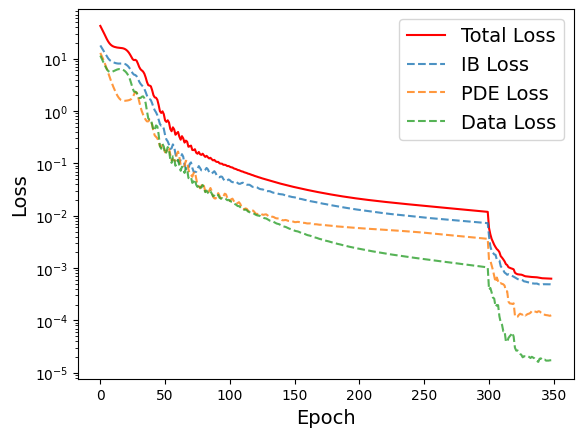

Final loss: 0.000622300068971929


In [6]:
model_name = 'american_call'
if TRAIN:
    nn = torch.nn.Sequential(
            torch.nn.Linear(2, 20),
            torch.nn.Tanh(),
            torch.nn.Linear(20, 20),
            torch.nn.Tanh(),
            torch.nn.Linear(20, 20),
            torch.nn.Tanh(),
            torch.nn.Linear(20, 1)
    )
    model = AmericanPINN(nn, K, T, r, sigma, S_inf, device=device, type='call').to(device)

    training_time = time()
    loss_weights = [1, 1, 1]
    # First train with Adam
    model.train(S_ib, tau_ib, V_ib, S_pde, tau_pde, S_data, tau_data, V_data,
                loss_weights=loss_weights,
                epochs=300, optimizer='adam', lr=0.01)
    # Then train with L-BFGS
    model.train(S_ib, tau_ib, V_ib, S_pde, tau_pde, S_data, tau_data, V_data,
                loss_weights=loss_weights,
                epochs=50, optimizer='lbfgs', line_search_fn='strong_wolfe', lr=1)
    training_time = time() - training_time
    print('Training time:', training_time)
    # save model
    torch.save(model, f'models/{model_name}.pt')

model = torch.load(f'models/{model_name}.pt')
print('Number of parameters:', sum(p.numel() for p in model.parameters()))
model.plot_loss(data=True, save=False, title='')
print('Final loss:', model.loss_history['total'][-1])

MSE: 2.997154082400067e-05
RMSE: 0.005474627003184844
-0.043695151805877686 0.10238623380422318


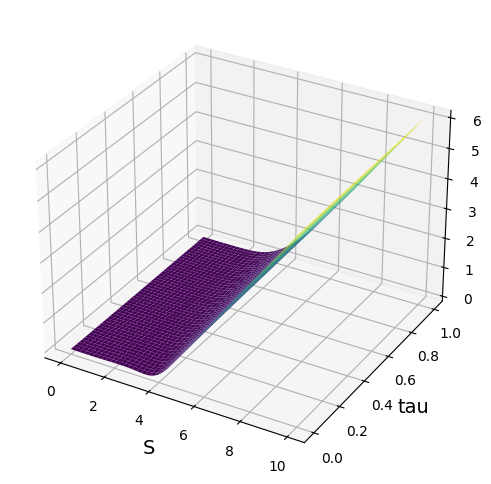

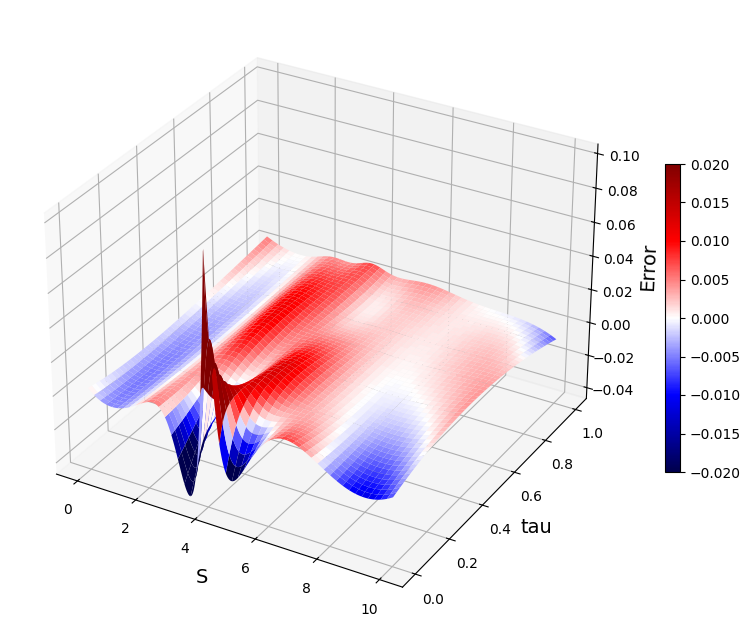

In [8]:
S_eval = torch.linspace(0, 10, 1000)
tau_eval = torch.linspace(0, T, 1000)
S_eval, tau_eval = torch.meshgrid(S_eval, tau_eval)  # torch meshgrid uses different indexing
V_pred = model(S_eval.reshape(-1, 1), tau_eval.reshape(-1, 1)).detach().numpy().reshape(1000, 1000).T

# compute error metrics
S_eval = np.linspace(0, 10, 1000)
tau_eval = np.linspace(0, T, 1000)
S_eval, tau_eval = np.meshgrid(S_eval, tau_eval)
V_true = V_BS(S_eval, tau_eval, K, r, sigma, 'call')
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d')
# surf = ax.plot_surface(S_eval, tau_eval, V_true, cmap='viridis')
V_err = V_pred - V_true
MSE = np.mean(V_err**2)
RMSE = np.sqrt(MSE)
print('MSE:', MSE)
print('RMSE:', RMSE)
print(V_err.min(), V_err.max())

# 3d plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(S_eval, tau_eval, V_pred, cmap='viridis')
ax.set_xlabel('S', fontsize=14)
ax.set_ylabel('tau', fontsize=14)
ax.set_zlabel('V', fontsize=14)
# ax.set_title('PINN Solution', fontsize=16)
plt.show()

# plot error surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(S_eval, tau_eval, V_err, label=f'PINN pointwise error\nRMSE: {RMSE:.2e}', cmap='seismic', vmin=-0.02, vmax=0.02)
cbar = fig.colorbar(surf, location='right', shrink=0.5)
# ax.set_zlim(-0.02, 0.02)
ax.set_xlabel('S', fontsize=14)
ax.set_ylabel('tau', fontsize=14)
ax.set_zlabel('Error', fontsize=14)
# ax.set_title('PINN Pointwise Error', fontsize=16)
plt.show()